In [377]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
from scipy.spatial import distance as dist
from scipy import sparse
from scipy.spatial import cKDTree as KDTree
import numba, argparse, gzip,pickle
import matplotlib.pyplot as plt
# from tqdm import tqdm
# from utils import RaDec2XYZ
# from IPython import embed
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


In [235]:
def RaDec2XYZ(ra,dec):
    """
    From (ra,dec) -> unit vector on the sphere
    """
    rar  = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    vec = np.array([x,y,z]).T

    return vec


# @numba.jit(parallel=True)
def CalculatePairwiseFlender(ra, dec, com_dists, field, sep_min=0, sep_max=300, nbins=20, flip_sign=False, nboot=20):
    assert(len(ra) == len(com_dists))

    nclusts = len(ra)
    delta_sep = (sep_max-sep_min)/nbins
    bins = np.arange(sep_min,sep_max+delta_sep,delta_sep)

    vec_unit = RaDec2XYZ(ra,dec) # Get unit vectors pointing to the clusters
    vec_dist = (vec_unit.T * com_dists).T # Mpc

    bootstrap_weight = np.zeros((nboot,nclusts))

    pairwise    = np.zeros((nboot,nbins))
    denominator = np.zeros((nboot,nbins))
    numerator   = np.zeros((nboot,nbins))
    npairs      = np.zeros((nboot,nbins))

    for b in range(nboot):
        for i in range(nclusts):
            r = np.random.randint(nclusts)
            bootstrap_weight[b][r] += 1

    if flip_sign: # NULL TEST !!!!
        for i in range(1, nclusts):
            npartners = 0
            for j in range(i):
                costheta = np.dot(vec_unit[i],vec_unit[j])
                com_sep  = np.sqrt(com_dists[i]**2 + com_dists[j]**2 -2*com_dists[i]*com_dists[j]*costheta)#; // comoving 

                if (com_sep >= sep_min) and (com_sep < sep_max):
                    this_bin = np.int(np.floor((com_sep-sep_min)/delta_sep))
                    f_ij = field[i] + field[j] # Note the plus instead of minus
                    c_ij = (com_dists[i]-com_dists[j]) * (1+costheta) / (2*com_sep)

                    for b in range(nboot):
                        numerator[b][this_bin]   += f_ij * c_ij * bootstrap_weight[b][i] * bootstrap_weight[b][j] 
                        denominator[b][this_bin] += c_ij **2 * bootstrap_weight[b][i] * bootstrap_weight[b][j] 
                        npairs[b][this_bin]      += bootstrap_weight[b][i] * bootstrap_weight[b][j]
    else:
        for i in range(1, nclusts):
            npartners = 0
            for j in range(i):
                costheta = np.dot(vec_unit[i],vec_unit[j])
                com_sep  = np.sqrt(com_dists[i]**2 + com_dists[j]**2 -2*com_dists[i]*com_dists[j]*costheta)#; // comoving 

                if (com_sep >= sep_min) and (com_sep < sep_max):
                    this_bin = np.int(np.floor((com_sep-sep_min)/delta_sep))
                    f_ij = field[i] - field[j] # Note the plus instead of minus
                    c_ij = (com_dists[i]-com_dists[j]) * (1+costheta) / (2*com_sep)

                    for b in range(nboot):
                        numerator[b][this_bin]   += f_ij * c_ij * bootstrap_weight[b][i] * bootstrap_weight[b][j] 
                        denominator[b][this_bin] += c_ij **2 * bootstrap_weight[b][i] * bootstrap_weight[b][j] 
                        npairs[b][this_bin]      += bootstrap_weight[b][i] * bootstrap_weight[b][j] 


    pw_bar = np.zeros(nbins)
    mu_nupairs = np.zeros(nbins)

    for k in range(nbins):
        for b in range(nboot):
            pairwise[b][k] = numerator[b][k]/denominator[b][k]
            pw_bar[k] += pairwise[b][k]
            mu_nupairs[k] += npairs[b][k]
        mu_nupairs[k] /= nboot
        pw_bar[k]     /= nboot


    # pw_cov = np.zeros((nbins,nbins))

    # for k in range(nbins):
    # 	for l in range(k):
    # 		for b in range(nboot):
    # 			pw_cov[k+1,l+1] += (pairwise[b][k] - pw_bar[k]) * (pairwise[b][l] - pw_bar[l])
    # 	pw_cov[k+1,l+1] /= nboot
    # 	pw_cov[l+1,k+1] = pw_cov[k+1,l+1]

    return pw_bar, pairwise

# @numba.jit( float64[:](float64[:],float64[:],float64[:],float64[:],int32,int32,int32,bool), nopython = True)
@numba.jit()#nopython=True)
def CalculatePairwiseCDist(ra, dec, com_dists, field, sep_min=0, sep_max=300, nbins=20, flip_sign=False):
    assert(len(ra) == len(com_dists))

    nclusts = len(ra)
    delta_sep = (sep_max-sep_min)/nbins
    bins = np.arange(sep_min,sep_max+delta_sep,delta_sep)

#     vec_unit = RaDec2XYZ(ra,dec) # Get unit vectors pointing to the clusters
    rar  = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    vec_unit = np.array([x,y,z]).T
    vec_dist = (vec_unit.T * com_dists).T # Mpc

    costheta = 1 - dist.cdist(vec_unit, vec_unit, 'cosine') # matrix with cos(theta_{ij}) as entries
    com_sep  = dist.cdist(vec_dist, vec_dist, 'euclidean')  # matrix with comoving separation between pairs of clusters
#     sep_max  = min(sep_max,bins[-1])

    pairwise    = np.zeros(len(bins)-1)
    denominator = np.zeros(len(bins)-1)
    numerator   = np.zeros(len(bins)-1)

    if flip_sign: # NULL TEST !!!!
        for i in range(1, nclusts):
            for j in range(i):
                if (com_sep[i,j] > sep_min) and (com_sep[i,j] < sep_max):
                    # this_bin = np.digitize(com_sep[i,j], bins) - 1 # find the right comoving separation bin
                    this_bin = np.int(np.floor((com_sep[i,j]-sep_min)/delta_sep))
                    f_ij = field[i] + field[j] # Note the plus instead of minus
                    c_ij = (com_dists[i]-com_dists[j]) * (1+costheta[i,j]) / (2*com_sep[i,j])

                    numerator[this_bin]   += f_ij * c_ij
                    denominator[this_bin] += c_ij**2
    else:
        for i in range(1, nclusts):
            for j in range(i):
                if (com_sep[i,j] > sep_min) and (com_sep[i,j] < sep_max):
#                     this_bin = np.digitize(com_sep[i,j], bins) - 1 # find the right comoving separation bin
                    this_bin = np.int(np.floor((com_sep[i,j]-sep_min)/delta_sep))
                    f_ij = field[i] - field[j]
                    c_ij = (com_dists[i]-com_dists[j]) * (1+costheta[i,j]) / (2*com_sep[i,j])
                    
#                     print i, j, f_ij, c_ij
                
                    numerator[this_bin]   += f_ij * c_ij
                    denominator[this_bin] += c_ij**2

#     print numerator, denominator
    pairwise = np.nan_to_num(numerator / denominator)

    return -1 * pairwise

def CalculatePairwiseKDTree(ra, dec, com_dists, field, sep_min=0, sep_max=300, nbins=20, flip_sign=False):
    assert(len(ra) == len(com_dists))

    nclusts = len(ra)
    delta_sep = (sep_max-sep_min)/nbins
    bins = np.arange(sep_min,sep_max+delta_sep,delta_sep)

    vec_unit = RaDec2XYZ(ra,dec) # Get unit vectors pointing to the clusters
    vec_dist = (vec_unit.T * com_dists).T # Mpc

    tree = KDTree(vec_dist)
    D    = tree.sparse_distance_matrix(tree, sep_max, p=2.0, output_type='ndarray')
    DU   = D[D['i'] < D['j']]

    pw = PairwiseKDTreeCore(DU, vec_unit, com_dists, field, bins, flip_sign)

    return pw

@numba.jit(parallel=True)
def PairwiseKDTreeCore(DU, vec_unit, com_dists, field, bins, flip_sign):
    nbins = len(bins)-1
    pairwise    = np.zeros(nbins)
    denominator = np.zeros(nbins)
    numerator   = np.zeros(nbins)

    if flip_sign:
        # Loop over separation bins
        for ir in range(nbins-1):
            DU_tmp = DU[(DU['v'] > bins[ir]) & (DU['v'] < bins[ir+1])]

            # Loop over pairs in a given r-bin
            for idx in range(len(DU_tmp)):
                costheta = np.dot(vec_unit[DU_tmp[idx]['i']],vec_unit[DU_tmp[idx]['j']])
                com_sep  = DU_tmp[idx]['v']

                f_ij = field[DU_tmp[idx]['i']] + field[DU_tmp[idx]['j']]
                c_ij = (com_dists[DU_tmp[idx]['i']]-com_dists[DU_tmp[idx]['j']]) * (1+costheta) / (2*com_sep)

                numerator[ir]   += f_ij * c_ij
                denominator[ir] += c_ij**2
    else:
        # Loop over separation bins
        for ir in range(nbins-1):
            DU_tmp = DU[(DU['v'] > bins[ir]) & (DU['v'] < bins[ir+1])]

            # Loop over pairs in a given r-bin
            for idx in range(len(DU_tmp)):
                costheta = np.dot(vec_unit[DU_tmp[idx]['i']],vec_unit[DU_tmp[idx]['j']])
                com_sep  = DU_tmp[idx]['v']

                f_ij = field[DU_tmp[idx]['i']] - field[DU_tmp[idx]['j']]
                c_ij = (com_dists[DU_tmp[idx]['i']]-com_dists[DU_tmp[idx]['j']]) * (1+costheta) / (2*com_sep)

                numerator[ir]   += f_ij * c_ij
                denominator[ir] += c_ij**2


    pairwise = numerator / denominator

    return -1 * pairwise

@numba.jit(parallel=True, )
def CalculatePairwiseData(ra, dec, com_dists, T_kSZ, sep_min=0, sep_max=300, nbins=20, flip_sign=False,):
    assert(len(ra) == len(com_dists))

    nclusts = len(ra)
    delta_sep = (sep_max-sep_min)/nbins

    rar  = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    vec_unit = np.array([x,y,z]).T
    vec_dist = (vec_unit.T * com_dists).T

    pairwise    = np.zeros(nbins)
    denominator = np.zeros(nbins)
    numerator   = np.zeros(nbins)
    npairs      = np.zeros(nbins)

    if flip_sign: # NULL TEST !!!!
        for i in range(1, nclusts):
            for j in range(i):
                costheta = np.dot(vec_unit[i],vec_unit[j])
                com_sep  = np.sqrt(com_dists[i]**2 + com_dists[j]**2 -2*com_dists[i]*com_dists[j]*costheta)#; // comoving 

                if (com_sep >= sep_min) and (com_sep < sep_max):
                    this_bin = np.int(np.floor((com_sep-sep_min)/delta_sep))
                    T_ij = T_kSZ[i] + T_kSZ[j] # Note the plus instead of minus
                    c_ij = (com_dists[i]-com_dists[j]) * (1+costheta) / (2*com_sep)

                    numerator[this_bin]   += T_ij * c_ij 
                    denominator[this_bin] += c_ij **2 
#             print("percent complete: %.2f"%(1.*i/(nclusts)*100)) 
    else:
        for i in range(1, nclusts):
            npartners = 0
            for j in range(i):
                costheta = np.dot(vec_unit[i],vec_unit[j])
                com_sep  = np.sqrt(com_dists[i]**2 + com_dists[j]**2 -2*com_dists[i]*com_dists[j]*costheta)#; // comoving 

                if (com_sep >= sep_min) and (com_sep < sep_max):
                    this_bin = np.int(np.floor((com_sep-sep_min)/delta_sep))
                    T_ij = T_kSZ[i] - T_kSZ[j] # Note the plus instead of minus
                    c_ij = (com_dists[i]-com_dists[j]) * (1+costheta) / (2*com_sep)

                    numerator[this_bin]   += T_ij * c_ij 
                    denominator[this_bin] += c_ij **2
#             print("percent complete: %.2f"%(1.*i/(nclusts)*100))



    return -1 * numerator/denominator



In [268]:
tab_fl_tSZ_AP  = pd.read_pickle('/Users/fbianchini/Research/kSZ/src/T_kSZ_tSZ_Flender_fwhm1.2arcmin_theta2.0arcmin_AP.pkl.gz')


In [269]:
tab_fl_tSZ_AP.columns

Index([u'DEC', u'M200', u'RA', u'TKSZ', u'VLOS', u'Z'], dtype='object')

In [270]:
tab_fl_tSZ_AP = tab_fl_tSZ_AP.sample(2000)

In [271]:
com_dists = cosmo.comoving_distance(tab_fl_tSZ_AP.Z).value

In [14]:
pw = CalculatePairwiseData(tab_fl_tSZ_AP.RA.values, tab_fl_tSZ_AP.DEC.values, com_dists, tab_fl_tSZ_AP.VLOS.values)

In [65]:
%timeit pw_cdist = CalculatePairwiseCDist(tab_fl_tSZ_AP.RA.values, tab_fl_tSZ_AP.DEC.values, com_dists, tab_fl_tSZ_AP.VLOS.values)

1 loop, best of 3: 2.61 s per loop


In [267]:
pw_cdist = CalculatePairwiseCDist(tab_fl_tSZ_AP.RA.values, tab_fl_tSZ_AP.DEC.values, com_dists, tab_fl_tSZ_AP.TKSZ.values)

In [66]:
%timeit pw_kdtree = CalculatePairwiseKDTree(tab_fl_tSZ_AP.RA.values, tab_fl_tSZ_AP.DEC.values, com_dists, tab_fl_tSZ_AP.VLOS.values)

1 loop, best of 3: 28.1 s per loop


In [48]:
pw_kdtree = CalculatePairwiseKDTree(tab_fl_tSZ_AP.RA.values, tab_fl_tSZ_AP.DEC.values, com_dists, tab_fl_tSZ_AP.VLOS.values)

In [49]:
bins= np.arange(0,315,15)
r = 0.5*(bins[1:]+bins[:-1])

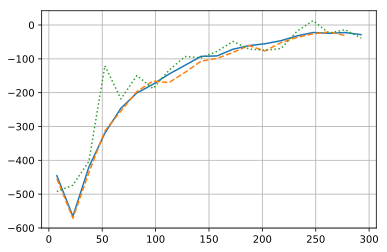

In [79]:
plt.plot(r,-pw_cdist)
plt.plot(r,-pw_kdtree, '--')
plt.plot(r,-pw, ":")
plt.grid()

In [217]:
def GetBootstrap(ra, dec, com_dists, field, sep_min=0, sep_max=300, nbins=20, nboot=25, flip_sign=False):
    nclusts = len(ra)
    delta_sep = (sep_max-sep_min)/nbins
    bins = np.arange(sep_min,sep_max+delta_sep,delta_sep)

    pw_bs = np.zeros((nboot,len(bins)-1))

    # Bootstrap estimation of covariance matrix
    print("...calculate covariance through bootstrap...")
    # for i in tqdm(range(nboot)):
    for i in range(nboot):
        idx = np.random.choice(np.arange(len(ra)), size=len(ra))
#         print len(ra), len(np.unique(idx))
        ra_tmp = ra[idx]
        dec_tmp = dec[idx]
        com_dists_tmp = com_dists[idx]
        field_tmp = field[idx]
#         print field_tmp
        pw_bs[i] = CalculatePairwiseCDist(ra_tmp, dec_tmp, com_dists_tmp, field_tmp, sep_min=sep_min, sep_max=sep_max, flip_sign=flip_sign)

    return pw_bs

In [280]:
bs = GetBootstrap(tab_fl_tSZ_AP.RA.values, tab_fl_tSZ_AP.DEC.values, com_dists, tab_fl_tSZ_AP.TKSZ.values, nboot=1000)

...calculate covariance through bootstrap...


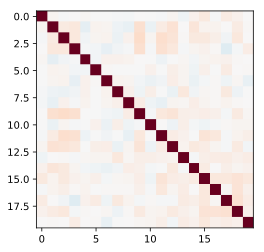

In [281]:
plt.imshow(np.corrcoef(bs.T),vmin=-1.,vmax=1,cmap='RdBu_r')
# plt.imshow(np.corrcoef(bs.T),vmin=.,vmax=1,cmap='magma')

In [282]:
idx = np.random.choice(np.arange(len(tab_fl_tSZ_AP.RA.values)), size=len(tab_fl_tSZ_AP.RA.values))
print len(tab_fl_tSZ_AP.RA.values), len(np.unique(idx))
ra_tmp = tab_fl_tSZ_AP.RA.values[idx]
dec_tmp = tab_fl_tSZ_AP.DEC.values[idx]
com_dists_tmp = com_dists[idx]
field_tmp = tab_fl_tSZ_AP.TKSZ.values[idx]
pw_bs = CalculatePairwiseCDist(ra_tmp, dec_tmp, com_dists_tmp, field_tmp, sep_min=0, sep_max=300, flip_sign=0)
# pw_bs_2 = CalculatePairwiseCDist(tab_fl_tSZ_AP.RA.values[:50], tab_fl_tSZ_AP.DEC.values[:50], com_dists[:50], tab_fl_tSZ_AP.VLOS.values[:50], sep_min=0, sep_max=300, flip_sign=0)


2000 1264


In [283]:
pw_bs

array([-2.69354325, -1.24024563, -1.0119831 , -2.87384911, -1.20060626,
       -1.93904098, -0.70038593, -0.77839763, -0.69645534, -0.67052433,
       -0.81370847, -0.72469532, -1.07618869,  0.01182167, -0.81871663,
       -0.08451347, -0.58830277, -0.12127688, -0.15798955,  0.01756155])

Text(0,0.5,'$T^{\\rm kSZ}$')

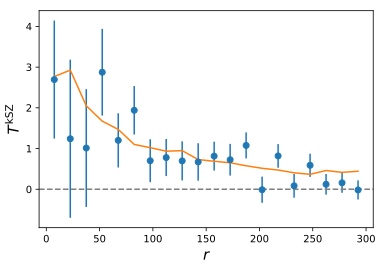

In [391]:
plt.errorbar(r, -pw_bs, yerr=np.sqrt(np.diag(np.cov(bs.T))), fmt='o')
# plt.plot(r, pw_bs_2)
plt.plot(r, -pw_cdist)
plt.axhline(c='grey',ls='--')
plt.xlabel(r'$r$',size=15)
plt.ylabel(r'$T^{\rm kSZ}$',size=15)

In [289]:
from cosmojo.profiles import convert_halo_mass
from cosmojo.universe import Cosmo

In [290]:
C = Cosmo()

In [347]:
convert_halo_mass(1e14, 0.5, 'critical', 'critical', 500, C)/1e14

0.67276144730661269

In [305]:
from scipy.integrate import dblquad

In [312]:
dblquad(lambda theta,phi: np.sin(theta), 0, 2*np.pi, lambda l:0, lambda l:np.pi)

(12.566370614359172, 1.3951473992034528e-13)

In [376]:
dblquad(lambda theta,phi: np.sin(theta), np.radians(45), np.radians(65), lambda l:np.radians(90-60), lambda l:np.radians(90-50))[0]/4/np.pi *42000

116.64445410970406

In [369]:
dblquad(lambda theta,phi: np.sin(theta), 0, np.radians(110), lambda l:np.radians(90-60), lambda l:np.radians(90-40))[0]/4/np.pi *42000

1432.4425121281874

In [393]:
0.25*500

125.0

In [373]:
3*np.sqrt(2)

4.2426406871192857

In [386]:
205-125


80